In [1]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q,approx_q_independent,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [427]:
lags = np.array([10,20,30,40,50,60,70,80,90,100])
vr_rates_dep = []
vr_rates_indep = []

In [549]:
N_burn = 1*10**4 # Burn in period\n",
N_train = 2*10**4 # Number of samples on which we optimize\n"
N_test = 2*10**3 # Number of samples\n",
step = 0.1 # Step size\n",
n_traj_train = 10
n_traj_test = 24 # Number of independent MCMC trajectories for test\n",
f_type = "sum_squares"
K_max = 2 #max degree of Hermite polynomial\n",
S_max = 2 #max degree of polynomial during regression stage\n",
lag = 100 #maximal lag order\n",
b_n_train = 20 #lag-window size\n",
b_n_test = int(np.round(N_test**(0.33)))
print(b_n_test)
degree = 2

12


In [550]:
d = 2
mu = 0.5*np.array([1.0,1.0],dtype = float)
#mu_1 = np.array([-1.0])
#mu_2 = np.array([1.0])
#Sigma_1 = np.array([[1.0]])
#Sigma_2 = np.array([[1.0]])
Sigma = GenerateSigma(d,rand_seed = 777,eps = 0.1) #covariation matrix 
p = 0.5
#Cur_pot = GausMixtureSame(Sigma,mu,p)
#Cur_pot = GaussMixture(Sigma_1,Sigma_2,mu_1,mu_2,p)
Cur_pot = GausMixtureIdent(mu,p)
r_seed = 777
x0 = np.array([0.0,0.0])
fixed_start = True

[1.94283271 0.1       ]


Choose sampler type (currently only ULA is maintained)

### Generate data

In [551]:
r_seed = 777
traj = np.zeros((n_traj_train,N_train,d),dtype = float)
for i in range(n_traj_train):
    cur_traj = ULA_light(r_seed+i,Cur_pot,step, N_burn, N_train, d, return_noise = False, x0 = x0, fixed_start = fixed_start)
    traj[i] = copy.deepcopy(cur_traj)
print(traj.shape)

(10, 20000, 2)


In [552]:
inds_arr = np.array([1]) # Taking the second index (not intercept)
params = None    
f_vals = set_function(f_type,traj,inds_arr,params) 
#f_vals = traj[:,:,0]
#f_vals = np.expand_dims(f_vals, axis=2)
print(f_vals.shape)

(10, 20000, 1)


In [553]:
n_traj_train_adv = 5*10**4
r_seed = 7771453
traj_adv = np.zeros((n_traj_train_adv,lag,d),dtype = float)
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(ULA_light, [(r_seed+i,Cur_pot,step, 100, lag, d, False,x0, False) for i in range (n_traj_train_adv)])
trav.close()

In [554]:
traj_adv = np.zeros((n_traj_train_adv,lag,d),dtype = float)
for i in range(n_traj_train_adv):
    traj_adv[i] = copy.deepcopy(res[i])
print(traj_adv.shape)
inds_arr = np.array([0]) # Taking the second index (not intercept)
params = None  
f_vals_adv = set_function(f_type,traj_adv,inds_arr,params)
print(f_vals_adv.shape)

(50000, 100, 2)
(50000, 100, 1)


### Evaluate baselines (EVM and ESVM methods)

In [411]:
sampler = {"sampler":"ULA","burn_type":"full","main_type":"full"} # Sampling method

if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj_train, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj_evm,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    raise "You should use ULA!"

ncores =  12


In [412]:
print(traj.shape)
inds_arr = np.array([0])#Taking the second index
params = None
f_vals_evm = set_function(f_type,traj_evm,inds_arr,params)

(10, 20000, 2)


In [ ]:
print(f_vals_evm)
print(f_vals)

In [ ]:
W_train_spec = construct_ESVM_kernel(N_train,b_n_train) #weight matrix for train
W_test_spec = construct_ESVM_kernel(N_test,b_n_test) #weight matrix for test
opt_structure_train = {
    "W":W_train_spec,
    "n_restarts": 3, # Number of restarts during optimization,
    "sigma": 1.0, # Deviation of starting points
    "tol": 1e-5, # Tolerance (for the norm of gradient)
    "alpha": 0.0, # Ridge penalty for 2nd order control functionals
    "beta": 10000.0 # smoothing parameter in the softmax
}
methods = ["ESVM","EVM"]

In [ ]:
coef_dict = optimize_parallel_new(degree,inds_arr,f_vals_evm,traj_evm,traj_grad,opt_structure_train,methods)
print(coef_dict)

In [ ]:
#Create a dictionary and put respective matrices into it
test_params = {
    "W":W_test_spec,
    "step":step,
    "burn_in":N_burn,
    "n_test":N_test,
    "dim":d
}

nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Run_eval_test, [(i,degree,sampler,methods,inds_arr,Cur_pot,test_params,coef_dict,params,f_type) for i in range (n_traj_test)])
trav.close()

In [ ]:
methods_enh = ['Vanilla'] + methods
print(methods_enh)
ints_result = {key: [] for key in methods_enh}
vars_result = {key: [] for key in methods_enh}

In [ ]:
for i in range(len(res)):
    for j in range(len(methods_enh)):
        ints_result[methods_enh[j]].append(res[i][0][methods_enh[j]][0])
        vars_result[methods_enh[j]].append(res[i][1][methods_enh[j]][0])
for key in methods_enh:
    ints_result[key] = np.asarray(ints_result[key])
    vars_result[key] = np.asarray(vars_result[key])

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [555]:
#polynomial coefficients
coefs_poly = approx_q(traj,f_vals,n_traj_train,lag,S_max)
print(coefs_poly.shape)

dimension =  20000
variance:  6.702868045316543
[0.         0.90741468 0.65454891 0.29431689 0.57304031 0.9374061
 0.76383494 0.59412309 0.46203256 0.24648966 0.57537072 0.72968888
 0.81268161 1.41162637 1.78086844 0.52340877 1.56689091 3.2579963
 2.3414917  3.06831816 2.00069112 1.40207901 2.08407094 0.41040167
 0.22571794 0.23392031 0.2123854  0.18994348 0.85975217 1.30127825
 1.61402353 3.48881818 3.65244436 1.82998464 3.16437655 1.38984319
 2.3516574  2.08530029 3.78269109 3.44230895 2.26537722 3.42642093
 2.95329933 2.867028   2.14395835 1.84603037 1.31517241 1.89509058
 1.01394214 1.14237399]
(200000, 6)
variance:  6.70285709564216
[0.90741468 0.65454891 0.29431689 0.57304031 0.9374061  0.76383494
 0.59412309 0.46203256 0.24648966 0.57537072 0.72968888 0.81268161
 1.41162637 1.78086844 0.52340877 1.56689091 3.2579963  2.3414917
 3.06831816 2.00069112 1.40207901 2.08407094 0.41040167 0.22571794
 0.23392031 0.2123854  0.18994348 0.85975217 1.30127825 1.61402353
 3.48881818 3.652444

(199810, 6)
variance:  6.703771831712698
[2.00069112 1.40207901 2.08407094 0.41040167 0.22571794 0.23392031
 0.2123854  0.18994348 0.85975217 1.30127825 1.61402353 3.48881818
 3.65244436 1.82998464 3.16437655 1.38984319 2.3516574  2.08530029
 3.78269109 3.44230895 2.26537722 3.42642093 2.95329933 2.867028
 2.14395835 1.84603037 1.31517241 1.89509058 1.01394214 1.14237399
 0.91499326 0.5132841  0.07672457 0.33283105 0.8377508  1.29892771
 1.41304709 0.15695956 0.13351647 1.31226078 3.19802242 3.41176376
 3.42345608 2.77995254 2.06317117 1.03948373 2.72037844 3.88117144
 3.24840132 4.41037942]
(199800, 6)
variance:  6.703728858841175
[1.40207901 2.08407094 0.41040167 0.22571794 0.23392031 0.2123854
 0.18994348 0.85975217 1.30127825 1.61402353 3.48881818 3.65244436
 1.82998464 3.16437655 1.38984319 2.3516574  2.08530029 3.78269109
 3.44230895 2.26537722 3.42642093 2.95329933 2.867028   2.14395835
 1.84603037 1.31517241 1.89509058 1.01394214 1.14237399 0.91499326
 0.5132841  0.07672457 0.3

(199580, 6)
variance:  6.704814502564552
[2.867028   2.14395835 1.84603037 1.31517241 1.89509058 1.01394214
 1.14237399 0.91499326 0.5132841  0.07672457 0.33283105 0.8377508
 1.29892771 1.41304709 0.15695956 0.13351647 1.31226078 3.19802242
 3.41176376 3.42345608 2.77995254 2.06317117 1.03948373 2.72037844
 3.88117144 3.24840132 4.41037942 4.60759733 1.94852068 2.03455516
 0.98952842 0.65497619 0.1304703  0.41715385 0.51884773 1.27419739
 1.747469   2.30468977 2.54691596 2.8394543  2.99302732 5.85108452
 5.28835835 5.67051572 5.51699234 2.3880747  2.67345519 5.12093651
 4.33722065 1.4250488 ]
(199570, 6)
variance:  6.7049068242961205
[2.14395835 1.84603037 1.31517241 1.89509058 1.01394214 1.14237399
 0.91499326 0.5132841  0.07672457 0.33283105 0.8377508  1.29892771
 1.41304709 0.15695956 0.13351647 1.31226078 3.19802242 3.41176376
 3.42345608 2.77995254 2.06317117 1.03948373 2.72037844 3.88117144
 3.24840132 4.41037942 4.60759733 1.94852068 2.03455516 0.98952842
 0.65497619 0.1304703  

variance:  6.707347198179296
[2.72037844e+00 3.88117144e+00 3.24840132e+00 4.41037942e+00
 4.60759733e+00 1.94852068e+00 2.03455516e+00 9.89528424e-01
 6.54976189e-01 1.30470305e-01 4.17153851e-01 5.18847734e-01
 1.27419739e+00 1.74746900e+00 2.30468977e+00 2.54691596e+00
 2.83945430e+00 2.99302732e+00 5.85108452e+00 5.28835835e+00
 5.67051572e+00 5.51699234e+00 2.38807470e+00 2.67345519e+00
 5.12093651e+00 4.33722065e+00 1.42504880e+00 1.22980907e+00
 2.36679773e+00 1.25953461e+00 7.64234630e-01 7.36116776e-01
 6.40258702e-01 6.59268497e-01 7.67081016e-01 1.03862837e-01
 2.96788802e-04 7.97819215e-03 1.79013287e-01 1.44047465e-03
 1.55825902e-01 3.84389894e-01 2.70674923e-01 3.72158062e-01
 1.86365348e-01 2.75487541e-01 9.04445231e-02 7.07925927e-01
 7.01382972e-01 6.66241726e-01]
(199340, 6)
variance:  6.707622366498222
[3.88117144e+00 3.24840132e+00 4.41037942e+00 4.60759733e+00
 1.94852068e+00 2.03455516e+00 9.89528424e-01 6.54976189e-01
 1.30470305e-01 4.17153851e-01 5.18847734e-0

(199230, 6)
variance:  6.7094372569368765
[1.27419739e+00 1.74746900e+00 2.30468977e+00 2.54691596e+00
 2.83945430e+00 2.99302732e+00 5.85108452e+00 5.28835835e+00
 5.67051572e+00 5.51699234e+00 2.38807470e+00 2.67345519e+00
 5.12093651e+00 4.33722065e+00 1.42504880e+00 1.22980907e+00
 2.36679773e+00 1.25953461e+00 7.64234630e-01 7.36116776e-01
 6.40258702e-01 6.59268497e-01 7.67081016e-01 1.03862837e-01
 2.96788802e-04 7.97819215e-03 1.79013287e-01 1.44047465e-03
 1.55825902e-01 3.84389894e-01 2.70674923e-01 3.72158062e-01
 1.86365348e-01 2.75487541e-01 9.04445231e-02 7.07925927e-01
 7.01382972e-01 6.66241726e-01 2.50391396e+00 2.66874209e+00
 3.16122027e+00 4.18840142e+00 1.85306139e+00 2.18553713e+00
 2.85017387e+00 5.94523589e+00 4.14764629e+00 4.39547246e+00
 2.74377974e+00 2.26089364e+00]
(199220, 6)
variance:  6.709471936680618
[1.74746900e+00 2.30468977e+00 2.54691596e+00 2.83945430e+00
 2.99302732e+00 5.85108452e+00 5.28835835e+00 5.67051572e+00
 5.51699234e+00 2.38807470e+00 

(199110, 6)
variance:  6.705417097398996
[5.12093651e+00 4.33722065e+00 1.42504880e+00 1.22980907e+00
 2.36679773e+00 1.25953461e+00 7.64234630e-01 7.36116776e-01
 6.40258702e-01 6.59268497e-01 7.67081016e-01 1.03862837e-01
 2.96788802e-04 7.97819215e-03 1.79013287e-01 1.44047465e-03
 1.55825902e-01 3.84389894e-01 2.70674923e-01 3.72158062e-01
 1.86365348e-01 2.75487541e-01 9.04445231e-02 7.07925927e-01
 7.01382972e-01 6.66241726e-01 2.50391396e+00 2.66874209e+00
 3.16122027e+00 4.18840142e+00 1.85306139e+00 2.18553713e+00
 2.85017387e+00 5.94523589e+00 4.14764629e+00 4.39547246e+00
 2.74377974e+00 2.26089364e+00 2.79172478e+00 2.46423774e+00
 1.57379176e+00 1.44214474e+00 2.02515803e+00 4.98972773e+00
 4.69900282e+00 3.13858541e+00 5.29691077e+00 2.15768940e+00
 3.02530604e+00 3.09263912e+00]
(199100, 6)
variance:  6.705072136453653
[4.33722065e+00 1.42504880e+00 1.22980907e+00 2.36679773e+00
 1.25953461e+00 7.64234630e-01 7.36116776e-01 6.40258702e-01
 6.59268497e-01 7.67081016e-01 1

In [556]:
coefs_poly_indep = approx_q_independent(traj_adv,f_vals_adv,n_traj_train_adv,lag,S_max)
print(coefs_poly.shape)

dimension =  100
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(50000, 6)
(500

### Use theoretically computed coefficients in regression

In [ ]:
print(coefs_poly.shape)
print(coefs_poly)
coefs_poly_theor = np.zeros_like(coefs_poly)
for ind in range(len(coefs_poly_theor)):
    if ind == 0:
        coefs_poly_theor[ind,0] = 0
    else:
        coefs_poly_theor[ind,0] = d*(1-(1-step)**(2*ind))/(1-step/2)   
    coefs_poly_theor[ind,3] = (1-step)**(2*ind)
    coefs_poly_theor[ind,5] = (1-step)**(2*ind)

Test our regressors

In [ ]:
cur_lag = 1
N_pts = 100
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(traj[0,cur_lag:N_pts],color='r',label='true function')
plt.plot(P.polynomial.polyval(traj[0,:N_pts-cur_lag],coefs_poly[cur_lag,:]),color='g',label = 'practical approximation')
#plt.plot(P.polynomial.polyval(X_train[0,:N_pts-cur_lag],coefs_poly_theor[cur_lag,:]),color='b',label = 'theoretical approximation')
plt.legend(loc = 'lower right',fontsize = 16)
plt.show()

In [557]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_dep = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


In [558]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_indep = trav.starmap(test_traj, [(Cur_pot,coefs_poly_indep,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


In [559]:
res_new_dep = np.asarray(res_dep)
res_new_indep = np.asarray(res_indep)

In [560]:
vars_vanilla_dep = np.var(res_new_dep[:,0,:],axis = 0)
vars_adj_dep = np.var(res_new_dep[:,1,:],axis = 0)
vr_rate_dep = vars_vanilla_dep[-1]/vars_adj_dep[-1]
print(vr_rate_dep)

vars_vanilla_indep = np.var(res_new_indep[:,0,:],axis = 0)
vars_adj_indep = np.var(res_new_indep[:,1,:],axis = 0)
vr_rate_indep = vars_vanilla_indep[-1]/vars_adj_indep[-1]
print(vr_rate_indep)

139.5571138115607
425.7205718530735


In [561]:
vr_rates_dep.append(vr_rate_dep)
vr_rates_indep.append(vr_rate_indep)

In [562]:
print(vr_rates_dep)

[22.493295464658384, 140.12958327196253, 148.50983793761634, 132.55495138142, 134.6123868447953, 149.96506940327802, 164.76760067310084, 164.63096228589387, 165.83747267949104, 139.5571138115607]


In [421]:
vr_rates_dep = np.asarray(vr_rates_dep)
vr_rates_indep = np.asarray(vr_rates_indep)
тp.save('vr_rate_dep_gmm_quadratic.npy',vr_rates_dep)
#np.save('vr_rate_indep_gmm_quadratic.npy',vr_rates_indep)
print(vr_rates_dep.shape)

(10,)


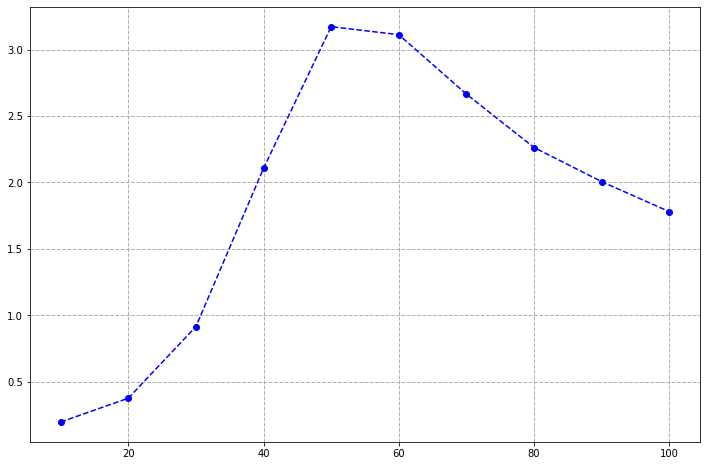

In [422]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
# plot the index for the x-values
#plt.plot(lags,vr_rates_dep/(lags*8), marker='o', linestyle='--', color='r', label='Train on dependent trajectories') 
plt.plot(lags,vr_rates_indep/(lags*2), marker='o', linestyle='--', color='b') #,label='Train on independent trajectories') 
#plt.xlabel('lag',fontsize = 18)
#plt.ylabel('cost',fontsize = 18) 
#plt.title('VR cost for MDCV, Gaussian distribution, quadratic target',fontsize = 20)
plt.grid(linestyle='--', linewidth=1.0)
#plt.legend() 
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
# plot the index for the x-values
#plt.plot(lags[:8],vr_rates_dep, marker='o', linestyle='--', color='r', label='Train on dependent trajectories') 
plt.plot(lags[:8],vr_rates_indep, marker='o', linestyle='--', color='b', label='Train on independent trajectories') 
#plt.xlabel('lag',fontsize = 18)
#plt.ylabel('VR rate',fontsize = 18) 
#plt.title('VR rates for MDCV, Gaussian Mixture, quadratic target',fontsize = 20)
plt.grid(linestyle='--', linewidth=1.0)
plt.legend() 
plt.show()

### Comparison plots

In [ ]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith MDCV', 'ULA \nwith EVM','ULA\nwith ESVM']

In [ ]:
data = [ints_result['Vanilla'][:,0],res_new[:,1,-1],ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['ULA \nwith MDCV', 'ULA \nwith EVM','ULA\nwith ESVM']

In [ ]:
data = [res_new[:,1,-1],ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)